In [164]:
import pandas as pd
import numpy as np  
import random
import matplotlib.pyplot as plt
import pickle
import os

In [213]:
with open('../Data/train_files.pickle', 'rb') as h:
    train_files = pickle.load(h)

with open('../Data/val_files.pickle', 'rb') as f:
    val_files = pickle.load(f)

with open('DictAreasTrain.pickle', 'rb') as g:
    DictAreasTrain = pickle.load(g)

with open('DictAreasVal.pickle', 'rb') as g:
    DictAreasVal = pickle.load(g)

train_labels = pd.read_csv("../Data/train_labels.csv",index_col="sample_id")
val_labels = pd.read_csv("../Data/val_labels.csv",index_col="sample_id")

from preprocess import preprocess

### Combining the area information into one dataframe

In [166]:
# Make dataframe to store all areas under the curve by m/z and temp_bin

import itertools

temp_bin = pd.interval_range(start=-100, end=1500, freq=100)

# Make dataframe with rows that are combinations of all temperature bins
# and all m/z values
temp = list(itertools.product(temp_bin, [*range(0, 100)]))

temp_df = pd.DataFrame(temp, columns=["temp_bin", "m/z"])

temp_df = temp_df.transpose()

# Rearrange data into dataframe for PCA that keeps bin information
# For each temperature bin, make a dataframe with the m/z values for all samples
# Get each dataframe with sample info

for sample, dataframe in DictAreasTrain.items():

    # Get the list of values in a single row
    df_list = dataframe.values.flatten()

         
    # Add the long row of values to the dataframe made in the previous cell
    temp_df.loc[len(temp_df)] = df_list

    

    
    
# Set the index of the array to the first two rows. The first part is the intervals, viewed as strings, and the second the 

temp_df.columns = pd.MultiIndex.from_arrays([temp_df.iloc[0].values.astype(str), temp_df.iloc[1].values])

# Keep the part of the dataframe starting from the third row (because the first two were made into headers)
temp_df = temp_df.iloc[2:]

temp_df.set_index(pd.Index(list(DictAreasTrain.keys())),inplace=True)

temp_df


(-100, 0]                                                         \
             0         1         2         3    4         5         6    
S0000       0.0       0.0       0.0       0.0  0.0       0.0       0.0   
S0001       0.0  0.078365  0.576336  0.059872  0.0  0.000967  0.000929   
S0002       0.0       0.0       0.0       0.0  0.0       0.0       0.0   
S0003       0.0       0.0       0.0       0.0  0.0       0.0       0.0   
S0004       0.0       0.0       0.0       0.0  0.0       0.0       0.0   
...         ...       ...       ...       ...  ...       ...       ...   
S0749       0.0       0.0       0.0       0.0  0.0       0.0       0.0   
S0750       0.0       0.0       0.0       0.0  0.0       0.0       0.0   
S0751       0.0  0.027547  0.145189  0.040087  0.0  0.000682  0.000318   
S0752       0.0       0.0       0.0       0.0  0.0       0.0       0.0   
S0753       0.0       0.0       0.0       0.0  0.0       0.0       0.0   

                                     ... (1400, 1500]                      \
             7         8         9   ...           90   91   92   93   94   
S0000       0.0       0.0       0.0  ...          0.0  0.0  0.0  0.0  0.0   
S0001  0.000733  0.000733  0.000817  ...          0.0  0.0  0.0  0.0  0.0   
S0002       0.0       0.0       0.0  ...          0.0  0.0  0.0  0.0  0.0   
S0003       0.0       0.0       0.0  ...          0.0  0.0  0.0  0.0  0.0   
S0004       0.0       0.0       0.0  ...          0.0  0.0  0.0  0.0  0.0   
...         ...       ...       ...  ...          ...  ...  ...  ...  ...   
S0749       0.0       0.0       0.0  ...          0.0  0.0  0.0  0.0  0.0   
S0750       0.0       0.0       0.0  ...          0.0  0.0  0.0  0.0  0.0   
S0751  0.000517  0.000476  0.000593  ...          0.0  0.0  0.0  0.0  0.0   
S0752       0.0       0.0       0.0  ...          0.0  0.0  0.0  0.0  0.0   
S0753       0.0       0.0       0.0  ...          0.0  0.0  0.0  0.0  0.0   

                                
        95   96   97   98   99  
S0000  0.0  0.0  0.0  0.0  0.0  
S0001  0.0  0.0  0.0  0.0  0.0  
S0002  0.0  0.0  0.0  0.0  0.0  
S0003  0.0  0.0  0.0  0.0  0.0  
S0004  0.0  0.0  0.0  0.0  0.0  
...    ...  ...  ...  ...  ...  
S0749  0.0  0.0  0.0  0.0  0.0  
S0750  0.0  0.0  0.0  0.0  0.0  
S0751  0.0  0.0  0.0  0.0  0.0  
S0752  0.0  0.0  0.0  0.0  0.0  
S0753  0.0  0.0  0.0  0.0  0.0  

[754 rows x 1600 columns]

Check the dataframe you get by fixing a column

In [177]:
temp_df[(   '(100, 200]',  44)]

S0000    0.020956
S0001    0.079475
S0002    0.007345
S0003    0.032245
S0004    0.089633
           ...   
S0749    2.932999
S0750    0.095369
S0751    0.038912
S0752    0.037529
S0753    0.004827
Name: ((100, 200], 44), Length: 754, dtype: object

### Principal Component Analysis
Let's do PCA on each temperature bin in temp_df array to reduce the number of features to train our models. I'll try PCA first on the first 100 columns (first temp bin). Make a plot of the cumulative explained variance to decide how many components to use for PCA.

Text(0, 0.5, 'cumulative explained variance')

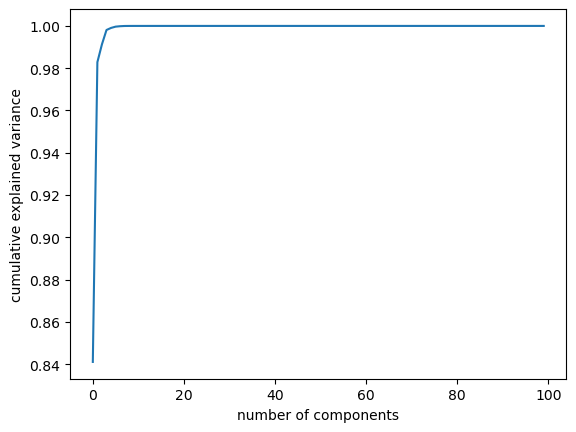

In [182]:
# import PCA
from sklearn.decomposition import PCA

# Try it on one dataframe
pca_df = temp_df.iloc[:, :100]

# Fit and make plot of explained variance ratio
principal_components = PCA().fit(pca_df)

# pca = PCA().fit(digits.data)
plt.plot(np.cumsum(principal_components.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')


From going through and making plots of a few random dataframes, overall it looks like we can capture most of the data with 3 components. So let's do PCA to 3 components for each dataframe and store that in a csv that can be used for modeling.

<Axes: >

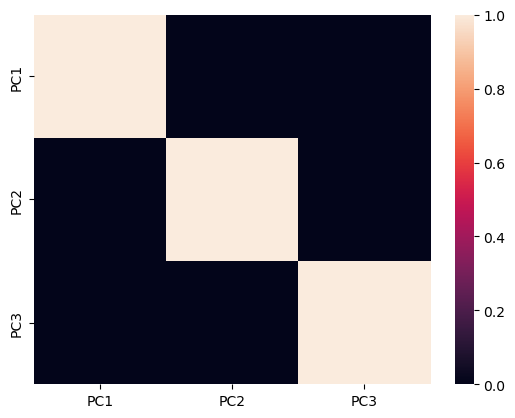

In [197]:
from sklearn.preprocessing import StandardScaler  # to standardize the features
import seaborn as sns

#Test the PCA with 3 components on the above dataframe
scaler = StandardScaler() 
scaled_data = pd.DataFrame(scaler.fit_transform(pca_df)) #scaling the data

#  Number of components for PCA
n_components = 3

# Make labels for columns
columns = []
for i in range(n_components):
    columns.append('PC'+str(i+1))

pca = PCA(n_components = n_components)
pca.fit(scaled_data)
data_pca = pca.transform(scaled_data)
data_pca = pd.DataFrame(data_pca,columns=columns)
    
sns.heatmap(data_pca.corr())
#data_pca

It looks like there is no correlation between the obtained principal components, so carrying out PCA accomplished our desired objective. Let's do these for each temperature bin (every 100 columns) in the dataframe.

In [211]:
# Import CSV to write outputs to file for modeling
import csv
# List to hold PCA dataframes
pca_concat_list = []

# Iterate through dataframe
for i in range(0, len(temp_df.columns), 100):
    subset_df = temp_df.iloc[:, i:i+100]
    #print(subset_df)
    # Standard scale the subset
    scaler = StandardScaler() 
    scaled_df = pd.DataFrame(scaler.fit_transform(subset_df))  

    # Carry out PCA with 3 components
    pca = PCA(n_components = 3)
    pca.fit(scaled_df)

    data_pca = pca.transform(scaled_df)


    data_pca = pd.DataFrame(data_pca)
    pca_concat_list.append(data_pca)

#print(pca_concat_list)
# Concatenate the dataframes
train_df = pd.concat(pca_concat_list, axis=1)

train_df.set_index(pd.Index(list(temp_df.index)),inplace=True)

train_df
    
  

,0,1,2,0,1,2,0,1,2,0,...,2,0,1,2,0,1,2,0,1,2
S0000,-0.621492,-0.165280,-0.125295,-0.784563,-1.268913,0.147361,-0.850240,-1.674688,-0.228735,-0.896297,...,-0.09684,-0.983755,-0.177357,-0.178857,-0.559546,-0.15498,-0.039571,-0.362594,-2.602069e-15,1.924227e-16
S0001,2.007919,3.813076,0.893565,-0.771116,-1.316065,-0.368455,-0.866575,-1.992731,-0.967201,-0.895989,...,-0.09684,-0.983755,-0.177357,-0.178857,-0.559546,-0.15498,-0.039571,-0.362594,-2.602069e-15,1.924227e-16
S0002,-0.621492,-0.165280,-0.125295,-0.757530,-0.833097,1.047529,-0.839254,-1.120552,0.780532,-0.903256,...,-0.09684,-0.983755,-0.177357,-0.178857,-0.559546,-0.15498,-0.039571,-0.362594,-2.602069e-15,1.924227e-16
S0003,-0.621492,-0.165280,-0.125295,-0.794925,-1.349837,-0.085693,-0.837493,-1.259507,0.268338,-0.900325,...,-0.09684,-0.983755,-0.177357,-0.178857,-0.559546,-0.15498,-0.039571,-0.362594,-2.602069e-15,1.924227e-16
S0004,-0.621492,-0.165280,-0.125295,-0.782964,-1.322934,-0.275282,-0.785496,-0.772100,0.888278,-0.830417,...,-0.09684,-0.983755,-0.177357,-0.178857,-0.559546,-0.15498,-0.039571,-0.362594,-2.602069e-15,1.924227e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S0749,-0.621492,-0.165280,-0.125295,-0.162081,0.546671,0.342431,-0.107018,1.277499,0.871815,-0.180641,...,-0.09684,-0.983755,-0.177357,-0.178857,-0.559546,-0.15498,-0.039571,-0.362594,-2.602069e-15,1.924227e-16
S0750,-0.621492,-0.165280,-0.125295,-0.775474,-1.443004,-0.449175,-0.838226,-1.865213,-0.726747,-0.858579,...,-0.09684,-0.983755,-0.177357,-0.178857,-0.559546,-0.15498,-0.039571,-0.362594,-2.602069e-15,1.924227e-16
S0751,1.185711,2.569778,3.077286,-0.513721,2.316029,7.273461,-0.732185,-0.011605,0.953857,-0.842814,...,-0.09684,-0.983755,-0.177357,-0.178857,-0.559546,-0.15498,-0.039571,-0.362594,-2.602069e-15,1.924227e-16
S0752,-0.621492,-0.165280,-0.125295,-0.772646,-1.342700,-0.591755,-0.801092,-1.235581,0.051681,-0.750540,...,-0.09684,-0.983755,-0.177357,-0.178857,-0.559546,-0.15498,-0.039571,-0.362594,-2.602069e-15,1.924227e-16


Save this dataframe into a csv file

In [231]:
train_df.to_csv("train_features_temp_bin_PCA.csv")

### A version of the above for the validation samples

In [214]:
# Make dataframe to store all areas under the curve by m/z and temp_bin

import itertools

temp_bin = pd.interval_range(start=-100, end=1500, freq=100)

# Make dataframe with rows that are combinations of all temperature bins
# and all m/z values
temp = list(itertools.product(temp_bin, [*range(0, 100)]))

temp_df_val = pd.DataFrame(temp, columns=["temp_bin", "m/z"])

temp_df_val = temp_df_val.transpose()

# Rearrange data into dataframe for PCA that keeps bin information
# For each temperature bin, make a dataframe with the m/z values for all samples
# Get each dataframe with sample info

for sample, dataframe in DictAreasVal.items():

    # Get the list of values in a single row
    df_list = dataframe.values.flatten()

         
    # Add the long row of values to the dataframe made in the previous cell
    temp_df_val.loc[len(temp_df_val)] = df_list

    

    
    
# Set the index of the array to the first two rows. The first part is the intervals, viewed as strings, and the second the 

temp_df_val.columns = pd.MultiIndex.from_arrays([temp_df_val.iloc[0].values.astype(str), temp_df_val.iloc[1].values])

# Keep the part of the dataframe starting from the third row (because the first two were made into headers)
temp_df_val = temp_df_val.iloc[2:]

temp_df_val.set_index(pd.Index(list(DictAreasVal.keys())),inplace=True)

temp_df_val

(-100, 0]                                               ...  \
             0    1    2    3    4    5    6    7    8    9   ...   
S0766       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
S0767       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
S0768       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
S0769       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
S0770       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
S1054       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
S1055       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
S1056       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
S1057       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
S1058       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

      (1400, 1500]                                               
                90   91   92   93   94   95   96   97   98   99  
S0766          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
S0767          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
S0768          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
S0769          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
S0770          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...            ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
S1054          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
S1055          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
S1056          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
S1057          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
S1058          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[293 rows x 1600 columns]

Try an entry to see if it looks reasonable:

In [219]:
temp_df_val[('(200, 300]',22)]

S0766    0.082787
S0767    0.007812
S0768    0.009745
S0769    0.001733
S0770    0.000451
           ...   
S1054    0.053471
S1055    0.011796
S1056    0.000479
S1057    0.072828
S1058    0.000764
Name: ((200, 300], 22), Length: 293, dtype: object

In [220]:
# List to hold PCA dataframes
pca_concat_list_val = []

# Iterate through dataframe
for i in range(0, len(temp_df_val.columns), 100):
    subset_df = temp_df_val.iloc[:, i:i+100]

    # Standard scale the subset
    scaler = StandardScaler() 
    scaled_df = pd.DataFrame(scaler.fit_transform(subset_df))  

    # Carry out PCA with 3 components
    pca = PCA(n_components = 3)
    pca.fit(scaled_df)

    data_pca = pca.transform(scaled_df)

    data_pca = pd.DataFrame(data_pca)
    pca_concat_list_val.append(data_pca)

#print(pca_concat_list_val)
# Concatenate the dataframes
val_df = pd.concat(pca_concat_list_val, axis=1)

val_df.set_index(pd.Index(list(temp_df_val.index)),inplace=True)

val_df
    
  

/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


,0,1,2,0,1,2,0,1,2,0,...,2,0,1,2,0,1,2,0,1,2
S0766,-0.976357,-0.229377,-0.034563,22.046827,-5.879006,1.524570,19.923507,-6.057228,5.473865,19.564997,...,-0.122813,-1.113710,-0.223269,0.103836,-0.817128,0.007707,-8.540918e-16,0.0,0.0,0.0
S0767,-0.976357,-0.229377,-0.034563,0.036201,-0.229938,0.085627,-0.110958,-0.244350,0.617746,-0.320294,...,-0.687253,2.973036,-1.090885,-0.703986,-0.817128,0.007707,-8.540918e-16,0.0,0.0,0.0
S0768,-0.976357,-0.229377,-0.034563,-0.380551,-0.340584,-0.329750,-0.125250,-0.472396,0.174374,0.239210,...,-0.122813,-1.113710,-0.223269,0.103836,-0.817128,0.007707,-8.540918e-16,0.0,0.0,0.0
S0769,-0.976357,-0.229377,-0.034563,-3.155193,0.466127,-0.261723,-3.089124,0.492821,-0.624859,-3.128206,...,-0.122813,-1.113710,-0.223269,0.103836,-0.817128,0.007707,-8.540918e-16,0.0,0.0,0.0
S0770,-0.976357,-0.229377,-0.034563,-3.194215,0.456838,-0.195257,-3.340360,0.535485,-0.480640,-3.519030,...,-0.122813,-1.113710,-0.223269,0.103836,-0.817128,0.007707,-8.540918e-16,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S1054,-0.976357,-0.229377,-0.034563,3.695691,-1.306718,0.059255,3.926218,-1.436770,1.350046,4.252797,...,-0.122813,-1.113710,-0.223269,0.103836,-0.817128,0.007707,-8.540918e-16,0.0,0.0,0.0
S1055,-0.976357,-0.229377,-0.034563,1.555823,-0.425438,4.444781,1.102363,-0.275541,3.410799,1.078125,...,-0.122813,-1.113710,-0.223269,0.103836,-0.817128,0.007707,-8.540918e-16,0.0,0.0,0.0
S1056,-0.976357,-0.229377,-0.034563,-3.214645,0.492821,-0.232106,-3.177070,0.504245,-0.409088,-3.585389,...,-0.122813,-1.113710,-0.223269,0.103836,-0.817128,0.007707,-8.540918e-16,0.0,0.0,0.0
S1057,-0.976357,-0.229377,-0.034563,-3.165299,0.481658,-0.294977,-2.692771,0.638160,-0.736294,-2.439355,...,-0.122813,-1.113710,-0.223269,0.103836,-0.817128,0.007707,-8.540918e-16,0.0,0.0,0.0


In [234]:
val_df.to_csv("val_features_temp_bin_PCA.csv")